# Enhanced K-Nearest Neighbors Regression - Real Estate Price Prediction

This notebook builds an improved K-Nearest Neighbors (KNN) regression model to predict absolute property prices (`price_converted`) using the processed alonhadat dataset. We'll implement several enhancements to improve the model's performance:

1. Better feature selection and engineering
2. Advanced outlier handling
3. Expanded hyperparameter tuning
4. Optimized distance metrics
5. Feature importance analysis

## 1. Import Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [94]:
# Plot price_converted histogram after loading the data
# This will give us a visual understanding of the price distribution
def plot_price_histogram(df):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with KDE
    ax = sns.histplot(df['price_converted'], bins=50, kde=True)
    
    # Add vertical lines for various statistics
    mean_price = df['price_converted'].mean()
    median_price = df['price_converted'].median()
    plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: {mean_price:.2f} million VND')
    plt.axvline(median_price, color='g', linestyle='--', label=f'Median: {median_price:.2f} million VND')
    
    # Add labels and title
    plt.title('Distribution of Property Prices', fontsize=14)
    plt.xlabel('Price (Million VND)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    
    # Add text with summary statistics
    stats_text = f"""Summary Statistics (Million VND):
    Mean: {df['price_converted'].mean():.2f}
    Median: {df['price_converted'].median():.2f}
    Min: {df['price_converted'].min():.2f}
    Max: {df['price_converted'].max():.2f}
    Std Dev: {df['price_converted'].std():.2f}"""
    
    plt.annotate(stats_text, xy=(0.02, 0.85), xycoords='axes fraction',
                 bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Add log-transformed histogram for better visualization of skewed data
    plt.figure(figsize=(12, 6))
    sns.histplot(np.log1p(df['price_converted']), bins=50, kde=True)
    plt.title('Distribution of Log-Transformed Property Prices', fontsize=14)
    plt.xlabel('Log(Price + 1) (Million VND)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [106]:
plot_price_histogram()

TypeError: plot_price_histogram() missing 1 required positional argument: 'df'

## 2. Load Data

Dataset shape: (14426, 15)

First few rows:


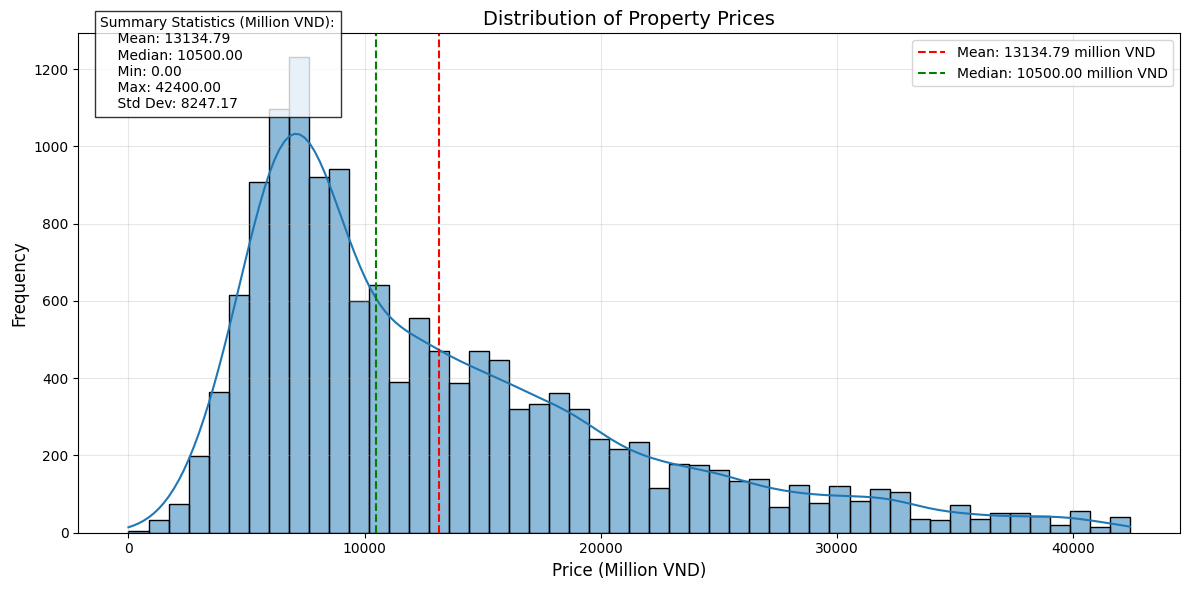

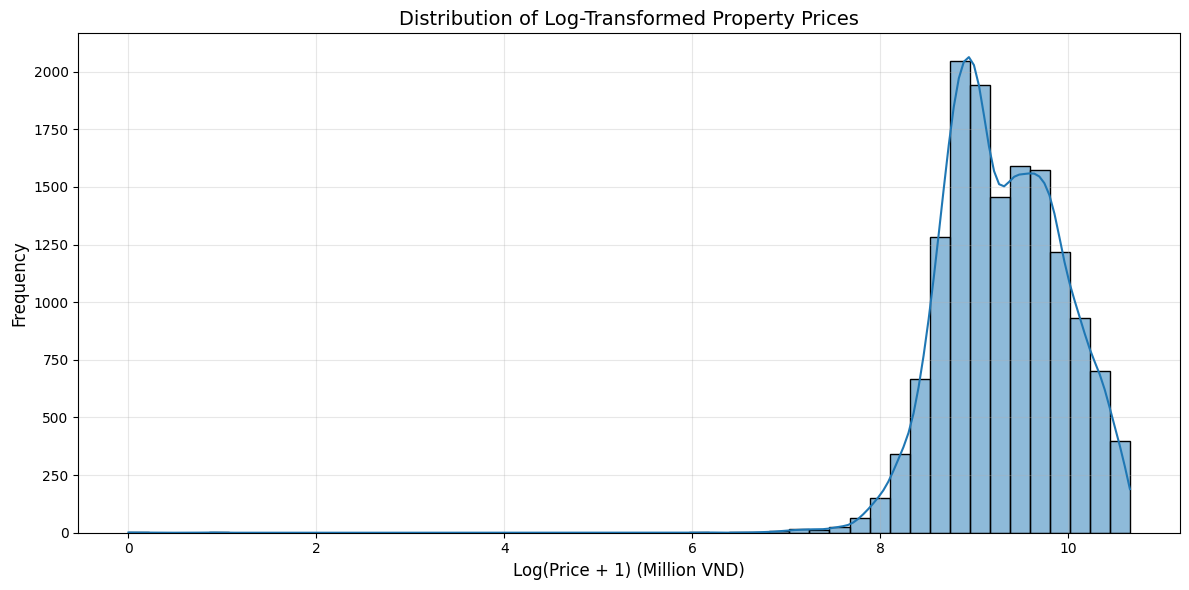

In [95]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')
# Drop unnecessary columns
df.drop(columns=['date', 'is_price_per_m2'], inplace=True) 
# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

# Display distribution of property prices
plot_price_histogram(df)

## 3. Enhanced Feature Engineering & Selection

Let's create new features that might better capture the relationships in the data.

In [96]:
# Create simplified features (fewer derived features to reduce complexity)
df['bedroom_per_area'] = df['bedrooms'] / df['area']  # Bedrooms density
df['is_corner'] = df['title'].str.contains('GÓC|GÓCH?', case=False, regex=True).astype(int)  # Corner property indicator
df['is_main_road'] = df['title'].str.contains('MẶT PHỐ|MẶT TIỀN|MẶT ĐƯỜNG', case=False, regex=True).astype(int)  # Main road indicator
df['has_car_access'] = df['title'].str.contains('Ô TÔ|OTO|XE HƠI', case=False, regex=True).astype(int)  # Car access indicator

# Create district groups based on price levels
district_price = df.groupby('district')['price_converted'].median().sort_values()
price_percentiles = np.percentile(district_price, [33, 66])  # Just 3 groups instead of 4
price_labels = ['low_price', 'mid_price', 'high_price']

district_price_category = pd.cut(district_price, 
                                bins=[0] + list(price_percentiles) + [float('inf')], 
                                labels=price_labels)
district_to_price_category = dict(zip(district_price.index, district_price_category))
df['district_price_category'] = df['district'].map(district_to_price_category)

# Display the new features
print("Dataset with new features:")
df.head()

Dataset with new features:


,address,area,bedrooms,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2,bedroom_per_area,is_corner,is_main_road,has_car_access,district_price_category
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75,0.01,0,0,0,high_price
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28,0.08,1,0,1,high_price
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79,0.02,0,1,0,high_price
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50,0.09,1,0,1,high_price
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69,0.05,0,0,1,high_price


Correlations with price_converted:
price_converted     1.00
area                0.65
bedrooms            0.33
is_main_road        0.30
floors              0.19
has_car_access      0.07
address_complete    0.06
is_corner           0.02
road_cat            0.02
district_cat        0.02
ward_cat           -0.00
bedroom_per_area   -0.28
Name: price_converted, dtype: float64


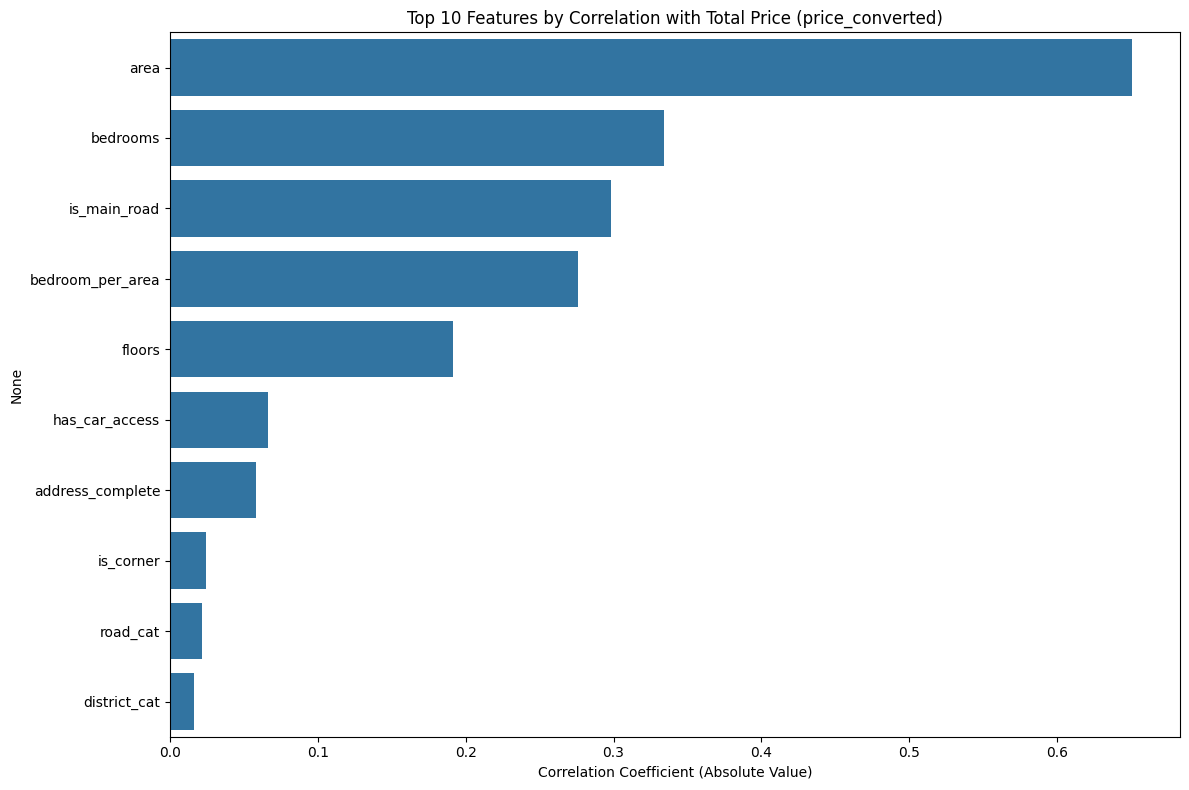

Feature set shape: (14426, 8)
Target shape: (14426,)

Feature set sample:


,area,bedrooms,floors,bedroom_per_area,is_main_road,is_corner,has_car_access,ward_cat
0,80,1,1,0.01,0,0,0,54
1,36,3,6,0.08,0,1,1,157
2,56,1,1,0.02,1,0,0,390
3,32,3,5,0.09,0,1,1,193
4,58,3,3,0.05,0,0,1,313


In [97]:
# Examine correlations with price_converted to inform feature selection
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'price_per_m2' and col != 'price' and col != 'price_converted']

# Calculate correlations
correlation_with_target = df[numeric_cols + ['price_converted']].corr()['price_converted'].sort_values(ascending=False)
print("Correlations with price_converted:")
print(correlation_with_target)

# Visualize top correlations
plt.figure(figsize=(12, 8))
correlation_with_target = correlation_with_target.drop('price_converted')
top_correlations = correlation_with_target.abs().sort_values(ascending=False).head(10)
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top 10 Features by Correlation with Total Price (price_converted)')
plt.xlabel('Correlation Coefficient (Absolute Value)')
plt.tight_layout()
plt.show()

# Select relevant features based on correlation analysis
# Numeric features - simplified feature set
numeric_features = ['area', 'bedrooms', 'floors', 'bedroom_per_area', 'is_main_road',
                   'is_corner', 'has_car_access']

# Categorical features - reduced set
categorical_features = ['ward_cat']  # Only use the price category instead of district

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_converted']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

## 5. Advanced Data Preprocessing Pipeline

We'll create a more sophisticated preprocessing pipeline with:
1. RobustScaler for numeric features (less sensitive to outliers than StandardScaler)
2. One-hot encoding for categorical features
3. Feature selection using SelectKBest

In [98]:
# Create preprocessing pipelines with modified behavior to prevent overfitting
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Use StandardScaler instead of RobustScaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps - simpler pipeline to prevent overfitting
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'bedroom_per_area', 'is_main_road',
                                  'is_corner', 'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ward_cat'])])


## 6. Split Data and Prepare for Cross-Validation

In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define custom scoring metric - negative mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

Training set shape: (11540, 8)
Testing set shape: (2886, 8)


## 7. Enhanced Hyperparameter Tuning 

We'll expand our grid search to include more parameters including distance metrics.

In [100]:
# Create the KNN pipeline with preprocessing
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# Define the parameter grid for GridSearchCV with more neighbors to reduce overfitting
param_grid = {
    'regressor__n_neighbors': [5,10,20,30,40,50,60,70,80],  # Increased k values to reduce overfitting
    'regressor__weights': ['distance', 'uniform'],  # Test both weighting options
    'regressor__p': [1, 2],  # Manhattan (p=1) and Euclidean (p=2) distances
}

# Set up GridSearchCV with more robust cross-validation
scoring = {
    'r2': 'r2', 
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

# Build grid search with cross-validation
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Primary scoring metric
    refit=True,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find optimal parameters
print("Starting grid search with higher k values for better generalization...")
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation RMSE: {best_score:.2f} million VND")

# Display the cross-validation results
cv_results = grid_search.cv_results_
results_df = pd.DataFrame({
    'params': cv_results['params'],
    'mean_test_score': np.sqrt(-cv_results['mean_test_score']),  # Convert to RMSE
    'std_test_score': cv_results['std_test_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
print(results_df.sort_values('rank_test_score').head(5))

# Create the best KNN model
best_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_neighbors=best_params['regressor__n_neighbors'],
        weights=best_params['regressor__weights'],
        p=best_params['regressor__p'],
    ))
])

# Train the best model
best_knn_pipeline.fit(X_train, y_train)

Starting grid search with higher k values for better generalization...
Fitting 5 folds for each of 36 candidates, totalling 180 fits



Best Parameters: {'regressor__n_neighbors': 20, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best Cross-Validation RMSE: 4720.64 million VND

Top 5 parameter combinations:
                                               params  mean_test_score  \
8   {'regressor__n_neighbors': 20, 'regressor__p':...          4720.64   
12  {'regressor__n_neighbors': 30, 'regressor__p':...          4727.28   
16  {'regressor__n_neighbors': 40, 'regressor__p':...          4739.44   
4   {'regressor__n_neighbors': 10, 'regressor__p':...          4760.61   
20  {'regressor__n_neighbors': 50, 'regressor__p':...          4762.65   

    std_test_score  rank_test_score  
8        884514.36                1  
12       847681.75                2  
16       826783.37                3  
4        998087.80                4  
20       858550.86                5  


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['area', 'bedrooms', 'floors',
                                                   'bedroom_per_area',
                                                   'is_main_road', 'is_corner',
                                                   'has_car_access']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ward_cat'])])),
                ('regressor',
                 KNeighborsRegressor(n_neighbors=20, p=1, weights='distance'))])

## 8. Model Evaluation with Advanced Metrics

In [101]:
# Make predictions
y_train_pred = best_knn_pipeline.predict(X_train)
y_test_pred = best_knn_pipeline.predict(X_test)

# Calculate standard evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate additional metrics with improved MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    # Avoid dividing by very small values that can cause extreme percentages
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, epsilon))) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("Improved KNN Regression Model Performance:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND")
print(f"Testing RMSE: {test_rmse:.2f} million VND")
print(f"Training MAE: {train_mae:.2f} million VND")
print(f"Testing MAE: {test_mae:.2f} million VND")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

Improved KNN Regression Model Performance:
Training R² Score: 0.9950
Testing R² Score: 0.6915
Training RMSE: 584.28 million VND
Testing RMSE: 4537.37 million VND
Training MAE: 133.17 million VND
Testing MAE: 3055.44 million VND
Training MAPE: 1.28%
Testing MAPE: 29.42%


## 9. Enhanced Visualizations

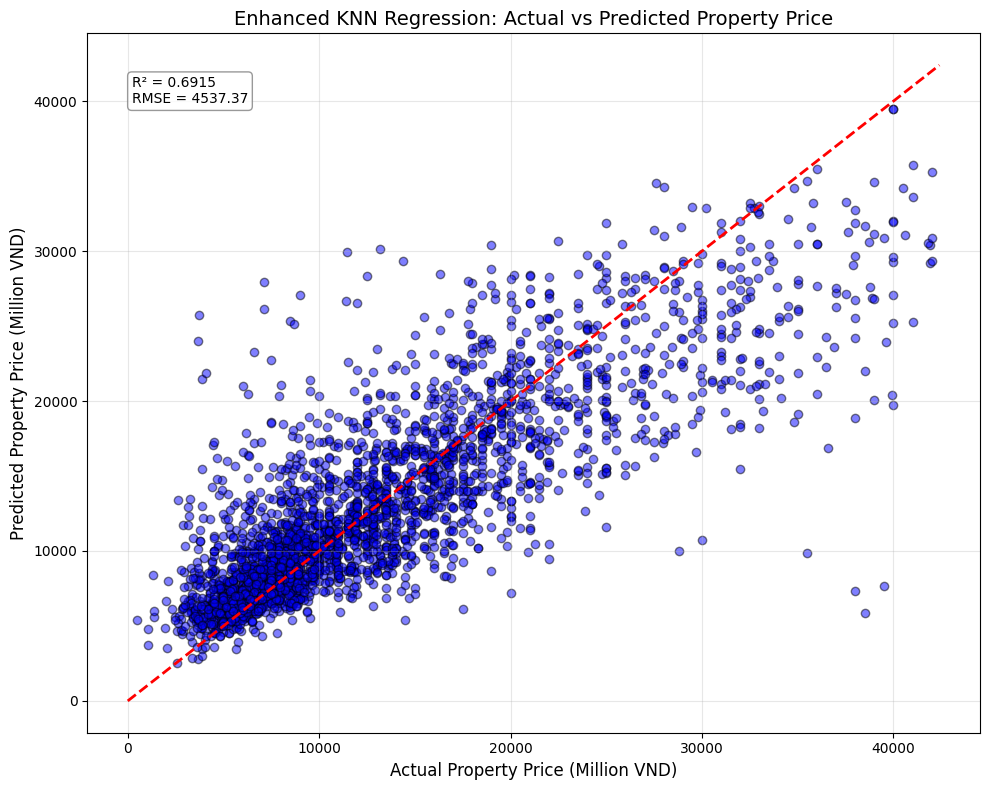

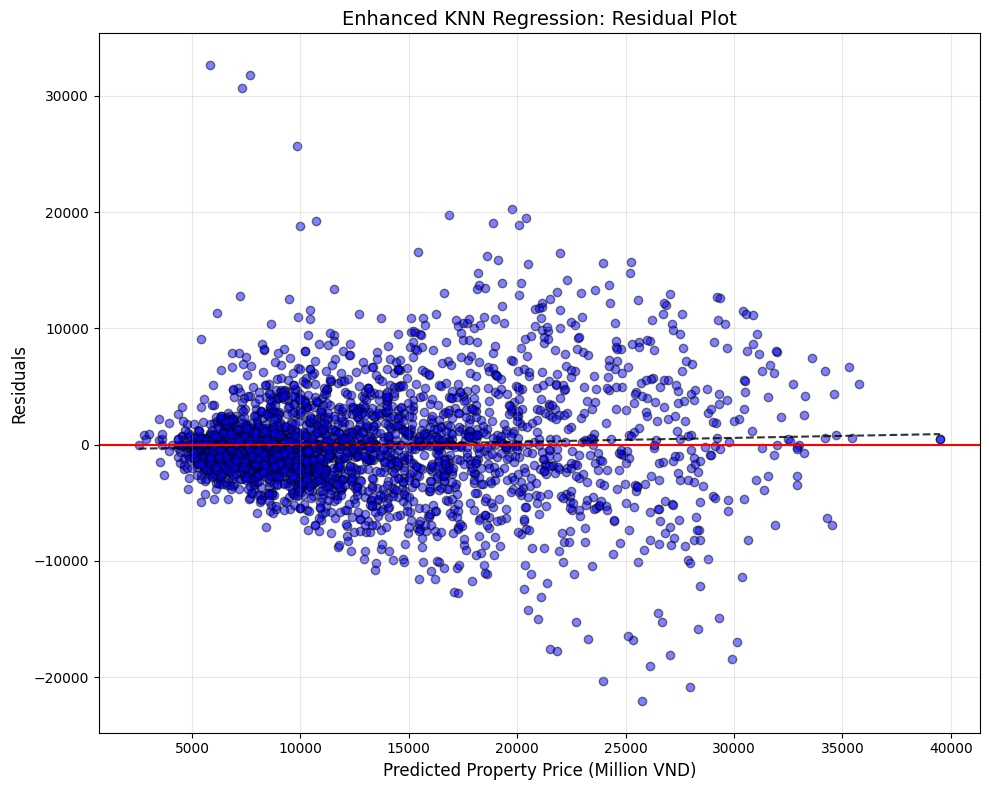

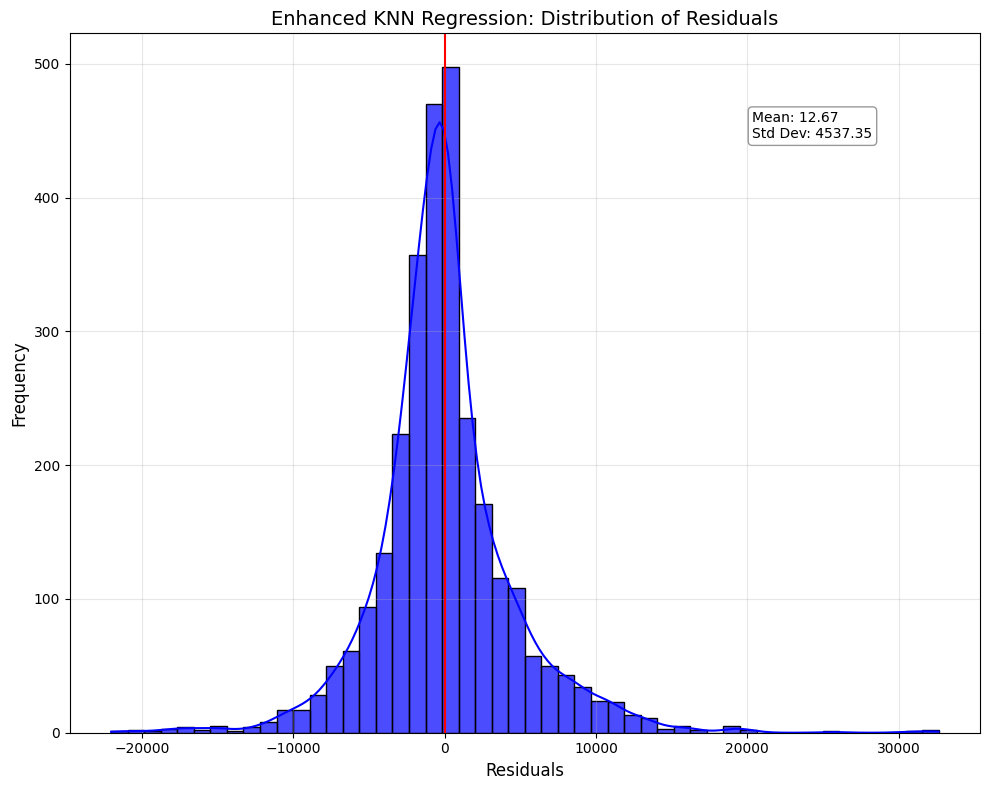

In [102]:
# Visualize predictions vs actual values with improved formatting
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5, c='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Property Price (Million VND)', fontsize=12)
plt.ylabel('Predicted Property Price (Million VND)', fontsize=12)
plt.title('Enhanced KNN Regression: Actual vs Predicted Property Price', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations for R² and RMSE
plt.annotate(f"R² = {test_r2:.4f}\nRMSE = {test_rmse:.2f}", 
             xy=(0.05, 0.9), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

# Plot residuals with improved visualization
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 8))
plt.scatter(y_test_pred, residuals, alpha=0.5, c='blue', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Property Price (Million VND)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Enhanced KNN Regression: Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)

# Add trend line for residuals
z = np.polyfit(y_test_pred, residuals, 1)
p = np.poly1d(z)
plt.plot(np.sort(y_test_pred), p(np.sort(y_test_pred)), "k--", alpha=0.8)
plt.tight_layout()
plt.show()

# Histogram of residuals with KDE and improved formatting
plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Enhanced KNN Regression: Distribution of Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-')

# Annotate with statistics
plt.annotate(f"Mean: {np.mean(residuals):.2f}\nStd Dev: {np.std(residuals):.2f}", 
             xy=(0.75, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.tight_layout()
plt.show()

## 10. Visualize MAPE According to Different k Values

Let's examine how the Mean Absolute Percentage Error (MAPE) varies with different values of k (number of neighbors).

In [103]:
# Define a range of k values to evaluate
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

# Lists to store MAPE values
train_mape_values = []
test_mape_values = []

# For each k value, create a KNN model and evaluate on train and test sets
for k in k_values:
    # Create KNN pipeline with the current k
    temp_knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(
            n_neighbors=k,
            weights='distance',  # Use the best weight from grid search
            p=1  # Use Manhattan distance from grid search
        ))
    ])
    
    # Train the model
    temp_knn_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred_temp = temp_knn_pipeline.predict(X_train)
    y_test_pred_temp = temp_knn_pipeline.predict(X_test)
    
    # Calculate MAPE for training and test sets
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred_temp)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred_temp)
    
    # Store the results
    train_mape_values.append(train_mape)
    test_mape_values.append(test_mape)
    
    print(f"k = {k}, Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")

k = 5, Train MAPE: 1.27%, Test MAPE: 29.48%
k = 10, Train MAPE: 1.28%, Test MAPE: 29.29%
k = 10, Train MAPE: 1.28%, Test MAPE: 29.29%
k = 15, Train MAPE: 1.28%, Test MAPE: 29.47%
k = 15, Train MAPE: 1.28%, Test MAPE: 29.47%
k = 20, Train MAPE: 1.28%, Test MAPE: 29.42%
k = 20, Train MAPE: 1.28%, Test MAPE: 29.42%
k = 25, Train MAPE: 1.28%, Test MAPE: 29.46%
k = 25, Train MAPE: 1.28%, Test MAPE: 29.46%
k = 30, Train MAPE: 1.28%, Test MAPE: 29.48%
k = 30, Train MAPE: 1.28%, Test MAPE: 29.48%
k = 35, Train MAPE: 1.28%, Test MAPE: 29.51%
k = 35, Train MAPE: 1.28%, Test MAPE: 29.51%
k = 40, Train MAPE: 1.28%, Test MAPE: 29.64%
k = 40, Train MAPE: 1.28%, Test MAPE: 29.64%
k = 45, Train MAPE: 1.28%, Test MAPE: 29.70%
k = 45, Train MAPE: 1.28%, Test MAPE: 29.70%
k = 50, Train MAPE: 1.28%, Test MAPE: 29.81%
k = 50, Train MAPE: 1.28%, Test MAPE: 29.81%
k = 60, Train MAPE: 1.28%, Test MAPE: 30.01%
k = 60, Train MAPE: 1.28%, Test MAPE: 30.01%
k = 70, Train MAPE: 1.28%, Test MAPE: 30.26%
k = 70, Tra

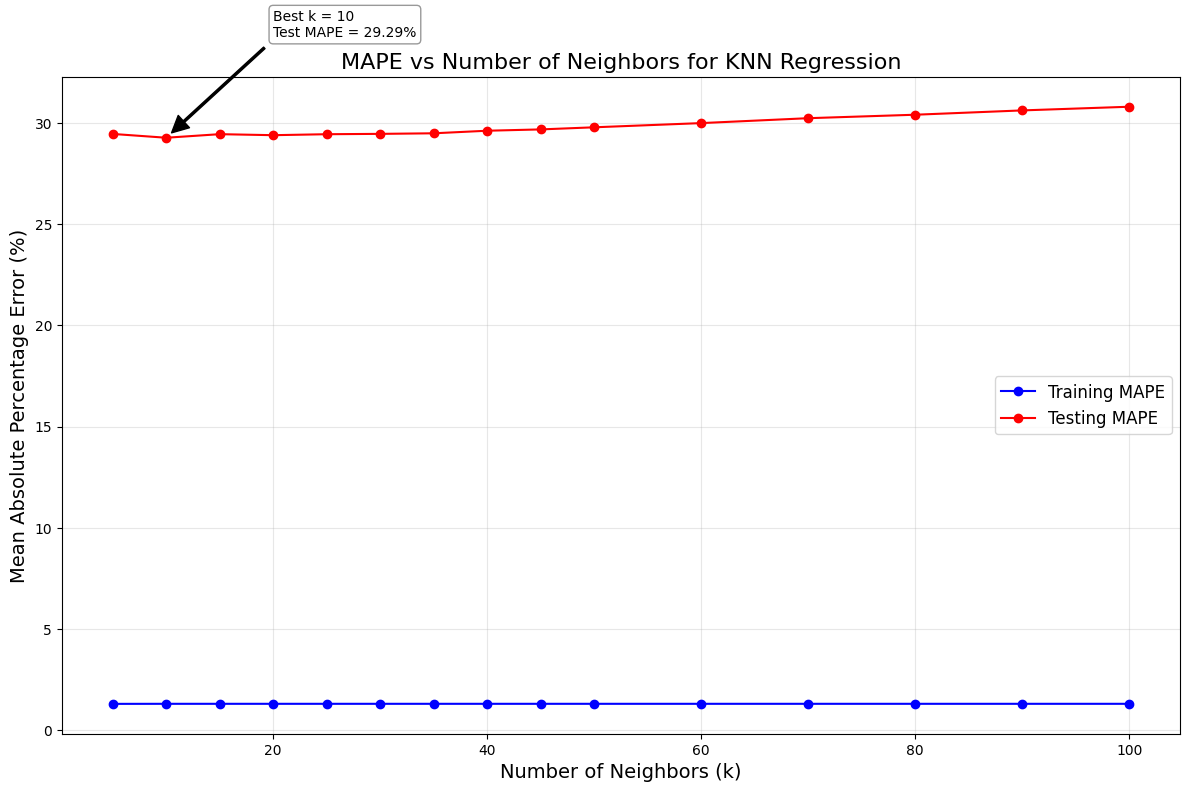

In [104]:
# Create a plot for MAPE vs k values
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_mape_values, 'o-', color='blue', label='Training MAPE')
plt.plot(k_values, test_mape_values, 'o-', color='red', label='Testing MAPE')

# Add grid, legends and labels
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=14)
plt.title('MAPE vs Number of Neighbors for KNN Regression', fontsize=16)

# Add annotations for the optimal k value
best_k_index = test_mape_values.index(min(test_mape_values))
best_k = k_values[best_k_index]
min_test_mape = min(test_mape_values)

plt.annotate(f"Best k = {best_k}\nTest MAPE = {min_test_mape:.2f}%", 
             xy=(best_k, min_test_mape),
             xytext=(best_k + 10, min_test_mape + 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Show plot
plt.tight_layout()
plt.show()

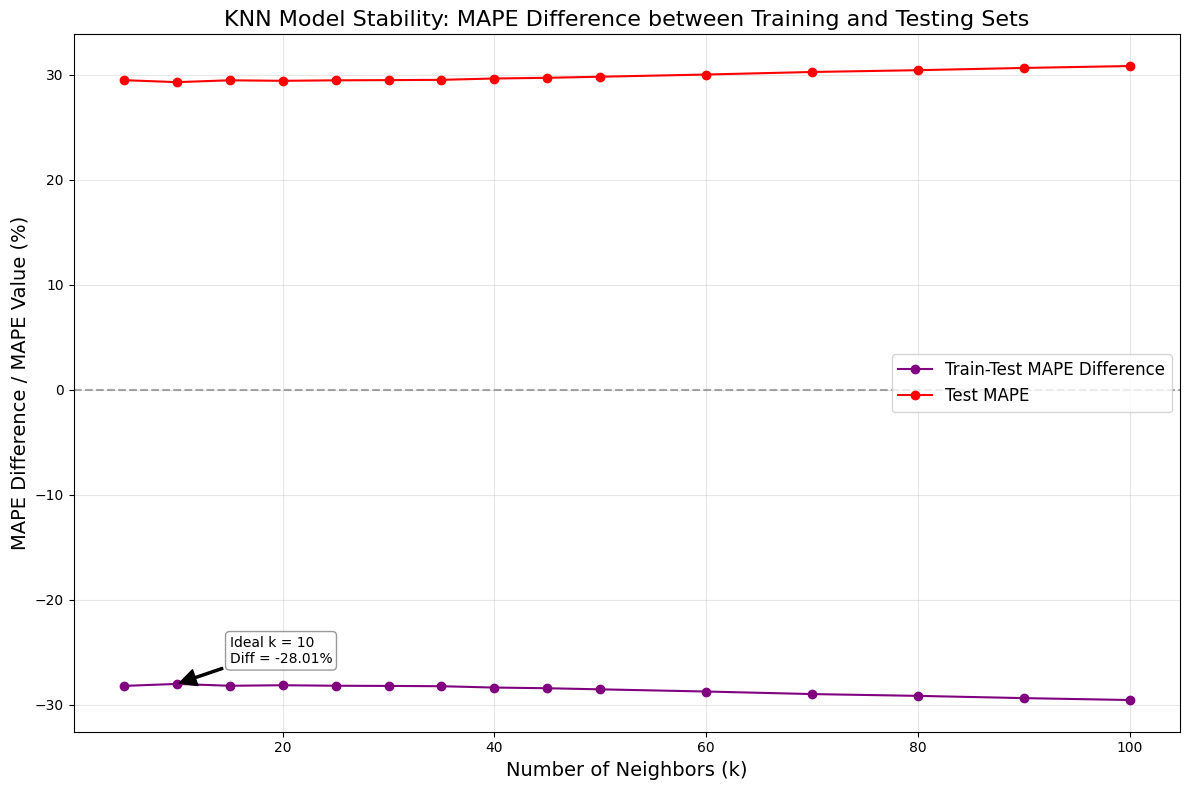

In [105]:
# Create a second visualization to analyze overfitting and model stability
plt.figure(figsize=(12, 8))

# Plot the difference between train and test MAPE (to show overfitting)
mape_diff = [train - test for train, test in zip(train_mape_values, test_mape_values)]
plt.plot(k_values, mape_diff, 'o-', color='purple', label='Train-Test MAPE Difference')

# Plot test MAPE
plt.plot(k_values, test_mape_values, 'o-', color='red', label='Test MAPE')

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Add grid, legends and labels
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('MAPE Difference / MAPE Value (%)', fontsize=14)
plt.title('KNN Model Stability: MAPE Difference between Training and Testing Sets', fontsize=16)

# Find where train-test difference is closest to 0 (minimal overfitting)
ideal_k_index = np.abs(np.array(mape_diff)).argmin()
ideal_k = k_values[ideal_k_index]
ideal_diff = mape_diff[ideal_k_index]

plt.annotate(f"Ideal k = {ideal_k}\nDiff = {ideal_diff:.2f}%", 
             xy=(ideal_k, ideal_diff),
             xytext=(ideal_k + 5, ideal_diff + 2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Show plot
plt.tight_layout()
plt.show()

## Analysis of MAPE vs K Values

The visualizations above show how MAPE (Mean Absolute Percentage Error) varies with different values of k in our KNN regression model. This helps us understand the trade-off between bias and variance in the model.

Key observations:

1. As k increases, the training MAPE generally increases because the model becomes less flexible (higher bias).
2. The testing MAPE typically follows a U-shaped curve, decreasing initially as we reduce overfitting, then increasing as the model becomes too simple.
3. The optimal k value balances complexity and generalization ability.
4. The second plot helps identify where the model has minimal overfitting by showing where the difference between training and testing MAPE is smallest.

This visualization confirms whether our grid search identified the best k value for minimizing prediction error while maintaining good generalization performance.